In [1]:
import numpy as np
import gzip
import os
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pingouin as pg
import vcf


from sklearn.preprocessing import scale
from scipy.stats import rankdata
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
from sklearn.impute import SimpleImputer

import sys
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code')
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code/scripts')
from get_unique_region_counts import *
from sNMF_plots import *
from get_isoforms import *
from get_unique_region_counts import *
from plot_factors import *
import tabix


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


loading modules
some more modules
custom-made modules
finished loading modules


In [2]:
def plot_factors_wrapper(rds, gene, ebpmf='ebpmf_10', strand='plus', colores=None, figsize=None, lm=True, factor_list = None, 
                         ax = None, xlim=None, plot_coords = False, lwidth=3, mute_y_axis = False):
    EF = pd.DataFrame(rds[ebpmf]['train_fit']['EF_smooth'][1:-1,:])
    EF.index = rds[ebpmf]['coords']

    if xlim is None:
        
        xlim1 = int(rds[ebpmf]['coords'][0].split(':')[1])-1000
        xlim2 = int(rds[ebpmf]['coords'][-1].split(':')[1])+1000
        xlim = (xlim1, xlim2)

    # xlim = (xlim1, xlim2)
    # print(xlim1, xlim2)
    
    EF.columns = [f'factor{str(i+1)}' for i in range(EF.shape[1])]

    if factor_list is not None:
        EF = EF[factor_list]
        EF = pd.DataFrame(EF)
        K = EF.shape[1]
        EF.columns = [f'factor{str(i)}' for i in range(1, K+1)]
    
    for factor in EF.columns:
        
        if lm:
            y = factor_lm(EF[factor], strand)
        else:
            y = np.array(EF[factor])
        EF[factor] = y
    plot_factor_tracks(EF/EF.quantile(0.99, axis=0), gene, EF.shape[1], colores = colores, figsize=figsize, ax=ax, 
                       xlim=xlim, plot_coords = plot_coords, mute_y_axis=mute_y_axis)


def plot_factor_tracks(EF, gene, K, title=None, fill=True, smooth=False, colores = None, q=0.99, figsize=None, ax=None, xlim=None, 
                       plot_coords=None, lwidth=None, mute_y_axis=False):

    EF = np.minimum(EF/EF.quantile(q, axis=0), 1)

    if colores is None:
        if K <= 5:
            colores = ['tab:blue', 'tab:orange', 'tab:green', 'goldenrod', 'tab:red'] 
        else:
            colores = sns.color_palette("tab10")
    
    if K <= 3:
        S = K
    else:
        S = K*0.8

    if figsize is None:
        figsize=(15, S)

    if ax is None:
        fig, ax = plt.subplots(nrows = K, figsize=figsize, gridspec_kw={'height_ratios': [2]*K, 
                                                                               'wspace': 0.3, 'hspace': 0.3})

    start = int(EF.index[0].split(':')[1])
    end = int(EF.index[-1].split(':')[1])
    length = EF.shape[0]
    
    coords = np.linspace(start, end, num=length)
    
    for i in range(K):
        factor = f'factor{i+1}'
        scaled_y = EF[factor]#/np.max(EF[factor])
        if fill:
            ax[i].fill_between(coords, np.zeros(len(coords)), scaled_y, color=colores[i], alpha=0.3)
#         else:
        ax[i].plot(coords, scaled_y, c=colores[i], alpha=0.9, linewidth=lwidth)
        
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        if (i < K-1) or (not plot_coords):
            ax[i].set_xticks([])
            ax[i].spines['bottom'].set_visible(False)

        if mute_y_axis:
            ax[i].spines['left'].set_visible(False)
            ax[i].set_yticks([])

        ax[i].set_xlim([xlim[0], xlim[1]])
        
        #ax[i].text(start+((end-start)*1.1), 0.9, factor, size=12)

    
        
    if title:
        fig.suptitle(title, fontsize=12, x=0.5, y=1.1)

    


###############

def plot_isoform_annotations(annotation_exons, gene, colores=None, start=None, end=None, figsize=None, lwidth=5, iso_order=None, axes=None, xlim=None):

    gene_exons = annotation_exons.loc[annotation_exons.gene_id == gene]

    if iso_order is None:
        isoforms = sorted(gene_exons.transcript_id.unique())
    else:
        isoforms = [gene + '.' + x for x in iso_order]

    isoform_dict = {}
    for i, iso in enumerate(isoforms):
        isoform_name = f'isoform_{str(i+1)}'
        df = gene_exons.loc[gene_exons.transcript_id == iso].copy()
        df['transcript_id'] =  f'{gene}.{isoform_name}'
        isoform_dict.update({isoform_name:{'df':df}})

    chrom = list(annotation_exons.chrom)[0]
    if start is None:
        start = str(np.min([int(list(gene_exons.start)[0]), int(list(gene_exons.start)[0])]) - 1000)
    if end is None:
        end = str(np.max([int(list(gene_exons.end)[-1]), int(list(gene_exons.end)[-1])]) + 1000)

    coords = [f'{chrom}:{start}', f'{chrom}:{end}']

    # print(isoform_dict)

    plot_gene_isoforms(isoform_dict, coords, color_list = colores, figsize=figsize, lwidth=lwidth, axes=axes, xlim=xlim)


def plot_gene_isoforms(isoforms_dict, coordinates, color_list = None, axes=None, figsize=None, lwidth=5, xlim=None):

    if xlim is None:
        xlim1 = int(coordinates[0].split(':')[1])
        xlim2 = int(coordinates[-1].split(':')[1])
    else:
        xlim1 = xlim[0]
        xlim2 = xlim[1]
    

    if color_list is None:
        color_list = sns.color_palette("tab10")

    K = len(isoforms_dict)

    if figsize is None:
        figsize=(20, 3)

    if axes is None:
        fig, axes = plt.subplots(K, 1, figsize=figsize)

    for i in range(K):
        isoform_df = isoforms_dict[f'isoform_{str(i+1)}']['df']
        # print(isoform_df)
        ax = axes[i]
        color = color_list[i]
        plot_isoform(isoform_df, ax, color, xlim[0], xlim[1], lwidth=lwidth)


def plot_isoform(isoform_df, ax, color, xlim1, xlim2, lwidth):
    # print(isoform_df)
    is_first = True
    for idx, row in isoform_df.iterrows():
        start = int(row.start)
        end = int(row.end)
        if is_first:
            first = end
            is_first = False
    
        ax.fill_between([start, end], [0, 0], [1, 1], color = color, zorder=2)
    
    ax.plot([first, start], [0.5, 0.5], c=color, linewidth=lwidth)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['bottom', 'top', 'right', 'left']].set_visible(False)
    ax.set_xlim([xlim1, xlim2])

    # print(xlim1, xlim2)


def plot_barh_ax(loadings, color, ax, label='label', sort_factor = False):
    x = range(len(loadings))
    if sort_factor:
        loadings = sorted(loadings) 
    ax.barh(x, loadings, width=4, color=color, alpha=0.7)
    if sort_factor:
        median = np.median(loadings)
        middle_point = len(loadings)/2
        ax.plot([0, len(loadings)], [median, median], linestyle = '--', c='black', linewidth=2)
        ax.scatter([middle_point], [median], marker="D", c = 'black', s=10)
    
    
    
def factor_barplot_h(EL, samples, color_list, label_list, sort_factor = False, figsize=None, ylim = None, one_row = False, 
                   tissue_colors = None, print_labels=False):
    samples = samples.loc[EL.index]
    tissues = samples.tissue_id.unique()
    factors = EL.columns
    
    K = len(factors)
    N = len(tissues)

    if figsize is None:
        figsize = (N/3,K/1.2)
    
    
    

    if one_row:
        fig, axes = plt.subplots(N+1,2, figsize=figsize, gridspec_kw={'wspace': 0.05, 'hspace': 0.1}, 
                             height_ratios = (([4]*N) + [1]), width_ratios = [1.2, 10])

        for j, tissue in enumerate(tissues):
            label = label_list[j]
            tissue_samples = samples.loc[samples.tissue_id == tissue].index


            EL_sorted = EL.loc[tissue_samples].sort_values(factors[0])
            
            #loadings = list(EL.loc[tissue_samples, factors[0]])

            ax = axes[j, 1]

            ax_ = axes[j, 0]
            ax_.barh([1], [1], color = tissue_colors[j])

            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])

            if j == 0:

                ax_ = axes[0, 1]
    
                ax_.axis('off')  # Hide
                ax_.margins(0, 0)
                ax_.spines['top'].set_visible(False)
                ax_.spines['bottom'].set_visible(False)
                ax_.spines['right'].set_visible(False)
                ax_.spines['left'].set_visible(False)
                ax_.set_xticks([])
                ax_.set_yticks([])

            loadings = np.array(EL_sorted[factors[0]])

            median = np.median(loadings)
            middle_point = len(loadings)/2
            for i, loading in enumerate(loadings):
                ax.plot([0, loading], [i, i], c=color_list[0])

                cum_sum = loading
                for j in range(1, len(factors)):
                    loading_ = EL_sorted.iloc[i,j]
                    if j == (len(factors)-1):
                        top_bar = 1
                    else:
                        top_bar = cum_sum + loading_
                    ax.plot([cum_sum, top_bar], [i, i], c=color_list[j])
                    cum_sum += loading_
                
                # ax.plot([i, i], [loading, 1], c=color_list[1])
                
            ax.plot([median, median], [len(loadings), 0], linestyle = '--', c='black', linewidth=2)
            ax.scatter([median], [middle_point], marker="D", c = 'black', s=10, zorder=len(loadings)+2)

            axes[N, 1].spines['top'].set_visible(False)
            axes[N, 1].spines['right'].set_visible(False)
            axes[N, 1].spines['left'].set_visible(False)
            axes[N, 1].set_yticks([])
            axes[N,1].tick_params(labelsize=10)
            if print_labels:
                ax.set_xlabel(label, rotation=45)

            if ylim is None:
                axes[N, 0].set_xlim([0,1])

                ax.set_xlim([0,1])
            else:
                axes[N, 0].set_xlim(ylim)
                ax.set_ylim(ylim)
            ax.spines['top'].set_visible(False)
            
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])

            ax_ = axes[N, 0]
    
            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])
            
            # ax[0].set_ylabel(factor)
            #plot_bar_ax(loadings, color, ax, label=label, sort_factor=True)

    # axes

    else:
        fig, axes = plt.subplots(K,N+1, figsize=figsize, gridspec_kw={'wspace': 0.1, 'hspace': 0.1}, 
                             width_ratios = ([1]+([4]*N)))
    
        for i, factor in enumerate(factors):
            color = color_list[i]
            
            axes[i,0].spines['top'].set_visible(False)
            axes[i,0].spines['right'].set_visible(False)
            axes[i,0].spines['bottom'].set_visible(False)
            axes[i,0].set_xticks([])
            axes[i,0].set_ylabel(factor)
            
            factor_max = EL[factor].max()
            
            axes[i,0].set_ylim([0,factor_max])
            
            for j, tissue in enumerate(tissues):
                if i == (len(factors)-1):
                    label = label_list[j]
                else:
                    label = ''
                tissue_samples = samples.loc[samples.tissue_id == tissue].index
                loadings = list(EL.loc[tissue_samples, factor])
                
                    
                ax = axes[i,j+1]
                plot_barh_ax(loadings, color, ax, label=label, sort_factor=sort_factor)
                
                ax.set_ylim([0,factor_max])
                ax.spines['top'].set_visible(False)
                
                ax.spines['left'].set_visible(False)
                ax.set_yticks([])
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.set_xticks([])
                
    
            #     ax.axis('off')  # Hide
                ax.margins(0, 0)
                
    
                ax.set_xlabel(label, rotation=45)



def plot_bar_ax(loadings, color, ax, label='label', sort_factor = False):
    x = range(len(loadings))
    if sort_factor:
        loadings = sorted(loadings) 
    ax.bar(x, loadings, width=4, color=color, alpha=0.7)
    if sort_factor:
        median = np.median(loadings)
        middle_point = len(loadings)/2
        ax.plot([0, len(loadings)], [median, median], linestyle = '--', c='black', linewidth=2)
        ax.scatter([middle_point], [median], marker="D", c = 'black', s=10)
    
    
    
def factor_barplot(EL, samples, color_list, label_list, tissue_colors, sort_factor = False):
    samples = samples.loc[EL.index]
    tissues = samples.tissue_id.unique()
    factors = EL.columns
    
    K = len(factors)
    N = len(tissues)
    
    
    fig, axes = plt.subplots(K+1,N+1, figsize=(N/3,K/1.5), gridspec_kw={'wspace': 0.1, 'hspace': 0.2}, 
                             width_ratios = ([1]+([4]*N)), height_ratios=[1]*K + [0.25])
    
    for i, factor in enumerate(factors):
        color = color_list[i]
        
        axes[i,0].spines['top'].set_visible(False)
        axes[i,0].spines['right'].set_visible(False)
        axes[i,0].spines['bottom'].set_visible(False)
        axes[i,0].set_xticks([])
        # axes[i,0].set_ylabel(factor)
        
        factor_max = EL[factor].max()
        
        axes[i,0].set_ylim([0,factor_max])
        
        for j, tissue in enumerate(tissues):
            if i == (len(factors)-1):
                label = label_list[j]
            else:
                label = ''
            tissue_samples = samples.loc[samples.tissue_id == tissue].index
            loadings = list(EL.loc[tissue_samples, factor])
            
                
            ax = axes[i,j+1]
            plot_bar_ax(loadings, color, ax, label=label, sort_factor=sort_factor)
            
            ax.set_ylim([0,factor_max])
            ax.spines['top'].set_visible(False)
            
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
            

        #     ax.axis('off')  # Hide
            ax.margins(0, 0)
            

            # ax.set_xlabel(label, rotation=45)


            ax_ = axes[K, j+1]
            ax_.barh([1], [1], color = tissue_colors[j])
    
            ax_.axis('off')  # Hide
            ax_.margins(0, 0)
            ax_.spines['top'].set_visible(False)
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['right'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_xticks([])
            ax_.set_yticks([])

    
            axes[K, 0].axis('off')  # Hide
            axes[K, 0].margins(0, 0)


In [3]:
participant = pd.read_csv('../data/participant.tsv', sep='\t', index_col=0)
gtex_samples = pd.read_csv('../code/config/samples.tsv', sep='\t', index_col=0)

tissue_sub_list = sorted(['Brain_Anterior_cingulate_cortex_BA24',
                      'Brain_Cortex',
                      'Brain_Frontal_Cortex_BA9',
                      'Brain_Putamen_basal_ganglia',
                      'Skin_Not_Sun_Exposed_Suprapubic',
                      'Liver',
                      'Lung', 
                      'Heart_Atrial_Appendage', 
                      'Muscle_Skeletal',
                      'Whole_Blood'])

In [4]:

def load_ebpmf_gene(gene_id):
    readRDS = ro.r['readRDS']
    df = readRDS(f'/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/RDS/{gene_id}.rds')
    with (ro.default_converter + pandas2ri.converter).context():
        pd_from_r_df = ro.conversion.get_conversion().rpy2py(df)

    output = pd_from_r_df

    return output

colores = np.array(sns.color_palette("tab10"))


def plot_factors_wrapper(rds, gene, ebpmf='ebpmf_10', strand='plus', colores=None, figsize=None, lm=True, factor_list = None, 
                         ax = None, xlim=None, plot_coords = False, lwidth=3, mute_y_axis = False):
    EF = pd.DataFrame(rds[ebpmf]['train_fit']['EF_smooth'][1:-1,:])
    EF.index = rds[ebpmf]['coords']

    if xlim is None:
        
        xlim1 = int(rds[ebpmf]['coords'][0].split(':')[1])-1000
        xlim2 = int(rds[ebpmf]['coords'][-1].split(':')[1])+1000
        xlim = (xlim1, xlim2)

    # xlim = (xlim1, xlim2)
    # print(xlim1, xlim2)
    
    EF.columns = [f'factor{str(i+1)}' for i in range(EF.shape[1])]

    if factor_list is not None:
        EF = EF[factor_list]
        EF = pd.DataFrame(EF)
        K = EF.shape[1]
        EF.columns = [f'factor{str(i)}' for i in range(1, K+1)]
    
    for factor in EF.columns:
        
        if lm:
            y = factor_lm(EF[factor], strand)
        else:
            y = np.array(EF[factor])
        EF[factor] = y
    plot_factor_tracks(EF/EF.quantile(0.99, axis=0), gene, EF.shape[1], colores = colores, figsize=figsize, ax=ax, 
                       xlim=xlim, plot_coords = plot_coords, mute_y_axis=mute_y_axis)


def plot_factor_tracks(EF, gene, K, title=None, fill=True, smooth=False, colores = None, q=0.99, figsize=None, ax=None, xlim=None, 
                       plot_coords=None, lwidth=None, mute_y_axis=False):

    EF = np.minimum(EF/EF.quantile(q, axis=0), 1)

    if colores is None:
        if K <= 5:
            colores = ['tab:blue', 'tab:orange', 'tab:green', 'goldenrod', 'tab:red'] 
        else:
            colores = sns.color_palette("tab10")
    
    if K <= 3:
        S = K
    else:
        S = K*0.8

    if figsize is None:
        figsize=(15, S)

    if ax is None:
        fig, ax = plt.subplots(nrows = K, figsize=figsize, gridspec_kw={'height_ratios': [2]*K, 
                                                                               'wspace': 0.3, 'hspace': 0.3})

    start = int(EF.index[0].split(':')[1])
    end = int(EF.index[-1].split(':')[1])
    length = EF.shape[0]
    
    coords = np.linspace(start, end, num=length)
    
    for i in range(K):
        factor = f'factor{i+1}'
        scaled_y = EF[factor]#/np.max(EF[factor])
        if fill:
            ax[i].fill_between(coords, np.zeros(len(coords)), scaled_y, color=colores[i], alpha=0.3)
#         else:
        ax[i].plot(coords, scaled_y, c=colores[i], alpha=0.9, linewidth=lwidth)
        
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        if (i < K-1) or (not plot_coords):
            ax[i].set_xticks([])
            ax[i].spines['bottom'].set_visible(False)

        if mute_y_axis:
            ax[i].spines['left'].set_visible(False)
            ax[i].set_yticks([])

        ax[i].set_xlim([xlim[0], xlim[1]])
        
        #ax[i].text(start+((end-start)*1.1), 0.9, factor, size=12)

    
        
    if title:
        fig.suptitle(title, fontsize=12, x=0.5, y=1.1)

    


###############

def plot_isoform_annotations(annotation_exons, gene, colores=None, start=None, end=None, figsize=None, lwidth=5, iso_order=None, axes=None, xlim=None):

    gene_exons = annotation_exons.loc[annotation_exons.gene_id == gene]

    if iso_order is None:
        isoforms = sorted(gene_exons.transcript_id.unique())
    else:
        isoforms = [gene + '.' + x for x in iso_order]

    isoform_dict = {}
    for i, iso in enumerate(isoforms):
        isoform_name = f'isoform_{str(i+1)}'
        df = gene_exons.loc[gene_exons.transcript_id == iso].copy()
        df['transcript_id'] =  f'{gene}.{isoform_name}'
        isoform_dict.update({isoform_name:{'df':df}})

    chrom = list(annotation_exons.chrom)[0]
    if start is None:
        start = str(np.min([int(list(gene_exons.start)[0]), int(list(gene_exons.start)[0])]) - 1000)
    if end is None:
        end = str(np.max([int(list(gene_exons.end)[-1]), int(list(gene_exons.end)[-1])]) + 1000)

    coords = [f'{chrom}:{start}', f'{chrom}:{end}']

    # print(isoform_dict)

    plot_gene_isoforms(isoform_dict, coords, color_list = colores, figsize=figsize, lwidth=lwidth, axes=axes, xlim=xlim)


def plot_gene_isoforms(isoforms_dict, coordinates, color_list = None, axes=None, figsize=None, lwidth=5, xlim=None):

    if xlim is None:
        xlim1 = int(coordinates[0].split(':')[1])
        xlim2 = int(coordinates[-1].split(':')[1])
    else:
        xlim1 = xlim[0]
        xlim2 = xlim[1]
    

    if color_list is None:
        color_list = sns.color_palette("tab10")

    K = len(isoforms_dict)

    if figsize is None:
        figsize=(20, 3)

    if axes is None:
        fig, axes = plt.subplots(K, 1, figsize=figsize)

    for i in range(K):
        isoform_df = isoforms_dict[f'isoform_{str(i+1)}']['df']
        # print(isoform_df)
        ax = axes[i]
        color = color_list[i]
        plot_isoform(isoform_df, ax, color, xlim[0], xlim[1], lwidth=lwidth)


def plot_isoform(isoform_df, ax, color, xlim1, xlim2, lwidth):
    # print(isoform_df)
    is_first = True
    for idx, row in isoform_df.iterrows():
        start = int(row.start)
        end = int(row.end)
        if is_first:
            first = end
            is_first = False
    
        ax.fill_between([start, end], [0, 0], [1, 1], color = color, zorder=2)
    
    ax.plot([first, start], [0.5, 0.5], c=color, linewidth=lwidth)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['bottom', 'top', 'right', 'left']].set_visible(False)
    ax.set_xlim([xlim1, xlim2])



import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

colores = np.array(sns.color_palette("tab10"))


def get_best_snp_record(vcf, phenotype, QTLs):
    
    chrom =QTLs.loc[phenotype, 'phe_chr'] 
    location = int(QTLs.loc[phenotype, 'var_id'].split(':')[1])
    
    location1 = int(QTLs.loc[phenotype, 'var_from'])
    location2 = int(QTLs.loc[phenotype, 'var_to'])
    
    record_list = []
    for record in vcf.fetch(chrom, location1-1, location2+1):  
        if record.POS == location:
#             print(chrom, location)
            return [record]
        record_list.append(record)
        
    return record_list

def get_snp_record(vcf, var_id):
    chrom, position, ref, alt, _ = var_id.split('_')
    position = int(position)
    record_out = None
    for record in vcf.fetch(chrom, position-1, position+1):  
        if (record.POS == position) and (record.REF == ref) and (alt in record.ALT):
            record_out = record
    return record_out
#             print(chrom, location)

gtex_vcf = vcf.Reader(open('/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/GTEx/data/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_866Indiv.vcf.gz', 'br'))



In [5]:
import tabix
from pybedtools import BedTool
from scipy.stats import linregress

import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

def run_tabix_on_junc(junc_file, coords, transform_to_df = True):
    chrom, start = coords[0].split(':')
    start = int(start)
    end = int(coords[-1].split(':')[1])
    
    tb = tabix.open(junc_file)
    juncs = tb.query(chrom, start, end)

    if transform_to_df:

        junctions_bed = []#pd.DataFrame()
        junctions_bed_cols = []
        
        # Iterate over queried junctions and store them in the DataFrame
        for idx, record in enumerate(juncs):
            junctions_bed.append(pd.Series(record))
            junctions_bed_cols.append(f'record{str(idx)}')
            # junctions_bed[f'record{str(idx)}'] = record
        # print(record)
        # print(junctions_bed)
        junctions_bed = pd.concat(junctions_bed, axis=1)
        junctions_bed.columns = junctions_bed_cols
        junctions_bed = junctions_bed.T
        return junctions_bed

    else:
        return juncs

def get_junctions_bed(coords, junc_file, gene_id, junc_thres=None):
    """
    Function: run_tabix
    
    Description:
    This function retrieves junction coordinates from a specified genomic region 
    using Tabix, and filters the junctions for a specific gene ID. It then formats 
    the retrieved junctions into a pandas DataFrame and converts them to a 
    BedTool object.
    
    Input:
    - coords: A list of genomic coordinates in the format 'chromosome:start-end'.
    - junc_file: A file path to a Tabix-indexed file containing junction information.
    - gene_id: A string representing the gene ID to filter the junctions.
    
    Output:
    - junctions_bed: A BedTool object containing junction coordinates for the specified gene ID, 
                     or an empty DataFrame if no junctions are found.
    """

    
    # Extract chromosome and start position from the first coordinate
    # chrom, start = coords[0].split(':')
    # start = int(start)
    # end = int(coords[-1].split(':')[1])
    
    # # Open Tabix file and query junctions within the specified genomic region
    # tb = tabix.open(junc_file)
    # juncs = tb.query(chrom, start, end)
    
    # # Create an empty DataFrame to store junctions
    # junctions_bed = pd.DataFrame()
    
    # # Iterate over queried junctions and store them in the DataFrame
    # for idx, record in enumerate(juncs):
    #     junctions_bed[f'record{str(idx)}'] = record
        
    # # Transpose the DataFrame and process gene IDs
    # junctions_bed = junctions_bed.T
    junctions_bed = run_tabix_on_junc(junc_file, coords)
    if junctions_bed.shape[0] == 0:
        junctions_bed = BedTool.from_dataframe(junctions_bed)
        return junctions_bed
    junctions_bed[3] = [x.split('.')[0] for x in junctions_bed[3]]

    junctions_bed_counts = junctions_bed.loc[junctions_bed[3] == gene_id, junctions_bed.columns[4:]].astype(int).quantile(0.999,axis=1)

    if junc_thres is None:
        junc_thres = junctions_bed_counts.max()/200
    
    # Filter junctions for the specified gene ID
    junctions_bed = junctions_bed.loc[junctions_bed[3] == gene_id, range(4)]
    junctions_bed.columns = ['chrom', 'start', 'end', 'gene']

    junctions_bed = junctions_bed[junctions_bed_counts >= junc_thres]
    
    # Return empty DataFrame if no junctions are found for the gene ID
    if junctions_bed.shape[0] == 0:
        junctions_bed = BedTool.from_dataframe(junctions_bed)
        return junctions_bed
    
    # Convert start and end positions to integers
    junctions_bed.start = junctions_bed.start.astype(int)
    junctions_bed.end = junctions_bed.end.astype(int)
    
    # Generate unique junction names
    junctions_bed['junc_names'] = ['junction_' + str(i) for i in range(1, junctions_bed.shape[0]+1)]
    
    # Rearrange DataFrame columns
    junctions_bed = junctions_bed[['chrom', 'start', 'end', 'junc_names']]
    
    # Convert DataFrame to BedTool object
    junctions_bed = BedTool.from_dataframe(junctions_bed)
    
    return junctions_bed


In [6]:
def prepare_QTL_metaplot(gene, tissue, var_id, counts = 'filtered'):
    counts = pd.read_csv(f'../code/coverage/counts_{counts}/{gene}.csv.gz', index_col=0)
    counts_ba9 = counts.loc[[x for x in counts.index if tissue in x]]
    counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]

    var_parts = var_id.split('_')
    var_loc = int(var_parts[1])
    rec_ = get_snp_record(gtex_vcf, var_id)
    ref = rec_.REF
    alt = str(rec_.ALT[0])
    hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
    hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
    hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)
    
    total_samples = hom_refs.union(hets).union(hom_alts)
    samples_intersect = counts_ba9.index.intersection(total_samples)
    
    
    rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

    first_pos = int(counts.columns[0].split(':')[1])
    coords = [int(x.split(':')[1]) for x in counts.columns]
    
    mean_counts_1 = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
    
    mean_counts_2 = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
    mean_counts_3 = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))

    out_dir = {'var':var_id,
               'var_pos':var_loc,
               'first_position':first_pos,
               'ref_allele':ref,
               'alt_allele':alt,
               'coords':coords,
               'alts_coverage':mean_counts_1,
               'het_coverage':mean_counts_2,
               'ref_coverage':mean_counts_3}
    
    return out_dir

In [7]:
# def plot_gene(gene, tissue, var_id, plot_var = True, smooth=50, xlim1 = False, xlim2=False, ylim=False, counts = 'filtered', var_h = 3):
#     counts = pd.read_csv(f'../code/coverage/counts_{counts}/{gene}.csv.gz', index_col=0)
#     counts_ba9 = counts.loc[[x for x in counts.index if tissue in x]]
#     counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]

    
    
#     # var_id = 'chr12_123940602_C_T_b38'
#     var_parts = var_id.split('_')
#     var_loc = int(var_parts[1])
#     rec_ = get_snp_record(gtex_vcf, var_id)
#     ref = rec_.REF
#     alt = str(rec_.ALT[0])
#     hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
#     hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
#     hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)
    
#     total_samples = hom_refs.union(hets).union(hom_alts)
#     samples_intersect = counts_ba9.index.intersection(total_samples)
    
    
#     rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

#     first_pos = int(counts.columns[0].split(':')[1])

#     print(var_loc)
#     print(first_pos)
#     fig, ax = plt.subplots(figsize = (10, 1.5))

    

    
#     mean_counts_1 = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
#     smoothed_mean = [np.mean(mean_counts_1[i:i+smooth]) for i in range(len(mean_counts_1))]
#     # x = range(first_pos, first_pos+len(smoothed_mean))
#     x_cols = [int(x.split(':')[1]) for x in counts.columns]
#     x = [np.mean(x_cols[i:i+smooth]) for i in range(len(x_cols))]
#     ax.plot(x, smoothed_mean, c = 'silver', label = f'{alt}/{alt}')
    
#     mean_counts_2 = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
#     smoothed_mean = [np.mean(mean_counts_2[i:i+smooth]) for i in range(len(mean_counts_2))]
#     ax.plot(x, smoothed_mean, c='gray', label=f'{ref}/{alt}')
    
#     mean_counts_3 = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))
#     smoothed_mean = [np.mean(mean_counts_3[i:i+smooth]) for i in range(len(mean_counts_3))]
#     ax.plot(x, smoothed_mean, c='black', label = f'{ref}/{ref}')
    
#     # var_loc = 56076841
#     if plot_var:
#         ax.plot([var_loc, var_loc], [0, var_h], linestyle='--', c='red', linewidth=2)
#     ax.legend(frameon=False)
#     ax.set_xlabel('chr19')
#     # ax.set_yticks([np.log1p(0), np.log1p(1), np.log1p(10)])
#     # ax.set_yticklabels(['0', '1', '10'])
#     ax.set_ylabel('normalized counts')

#     if xlim1 and xlim2:
#         ax.set_xlim([first_pos + xlim1, first_pos + xlim2])

#     if ylim:
#         ax.set_ylim([-0.02, ylim])

#     return mean_counts_1, mean_counts_2, mean_counts_3, x_cols
    
#     # ax.set_xlim([142130000, 142160000])

In [8]:
def plot_gene_counts(gene_dir, plot_var = True, smooth=50, xlim1 = False, xlim2=False, ylim=False, var_h = 3, ax=None,
                    colores = ['black', 'gray', 'silver'], linewidth=1):
    
    # out_dir = {'var':var_id,
    #            'var_pos':var_loc,
    #            'first_position':first_pos,
    #            'ref_allele':ref,
    #            'alt_allele':alt,
    #            'coords':coords,
    #            'alts_coverage':mean_counts_1,
    #            'het_coverage':mean_counts_2,
    #            'ref_coverage':mean_counts_3}

    var_id = gene_dir['var']
    chrom = var_id.split('_')[0]
    var_loc = gene_dir['var_pos']
    ref = gene_dir['ref_allele']
    alt = gene_dir['alt_allele']

    alts_counts = gene_dir['alts_coverage']
    hets_counts = gene_dir['het_coverage']
    refs_counts = gene_dir['ref_coverage']
    coords = gene_dir['coords']
    first_pos = gene_dir['first_position']

    smoothed_coords = [np.mean(coords[i:i+smooth]) for i in range(len(coords))]
    
    smoothed_mean_alts = [np.mean(alts_counts[i:i+smooth]) for i in range(len(alts_counts))]
    smoothed_mean_hets = [np.mean(hets_counts[i:i+smooth]) for i in range(len(hets_counts))]
    smoothed_mean_refs = [np.mean(refs_counts[i:i+smooth]) for i in range(len(refs_counts))]
    
    if ax is None:
        fig, ax = plt.subplots(figsize = (10, 1.5))
        ax.set_xlabel(chrom)

    

    ax.plot(smoothed_coords, smoothed_mean_alts,  label = f'{alt}/{alt}', c=colores[2], linewidth=linewidth)
    ax.plot(smoothed_coords, smoothed_mean_hets,  label = f'{ref}/{alt}', c=colores[1], linewidth=linewidth)
    ax.plot(smoothed_coords, smoothed_mean_refs,  label = f'{ref}/{ref}', c=colores[0], linewidth=linewidth)
    
    if plot_var:
        ax.plot([var_loc, var_loc], [0, var_h], linestyle='--', c='red', linewidth=2)
    
    ax.legend(frameon=False, bbox_to_anchor=(1, 1.1))
    # ax.set_xlabel(chrom)
    ax.set_xticks([])
    

    ax.set_ylabel('mean\ncounts')

    if xlim1 and xlim2:
        ax.set_xlim([first_pos + xlim1, first_pos + xlim2])

    if ylim:
        ax.set_ylim([-0.02, ylim])


def plot_isoforms(gene, annot_exons, isoform_list = None, xlim=None, ax=None, annot = 'snmf', colores = ['black']*100):
    rds = load_ebpmf_gene(gene)

    if not(isoform_list is None):
        if annot == 'snmf':
            isoforms = [f'{gene}.isoform_{str(i)}' for i in isoform_list]
        else:
            isoforms = isoform_list
    else:
        isoforms = annot_exons.loc[annot_exons.gene_id == gene].transcript_id.unique()
        
    annot_exons = annot_exons.loc[annot_exons.transcript_id.isin(isoforms)]
    
    if ax is None:

        fig, ax = plt.subplots(nrows = len(isoforms), figsize=(4, 1), gridspec_kw={'height_ratios': [1.5]*len(isoforms), 'hspace': 0.3})

    if xlim is None:
        xlim1 = int(rds['ebpmf_10']['coords'][0].split(':')[1])-1000
        xlim2 = int(rds['ebpmf_10']['coords'][-1].split(':')[1])+1000
        
        xlim = (xlim1, xlim2)


    plot_isoform_annotations(annot_exons, gene, colores = colores, axes=ax, xlim=xlim, lwidth=2.5, )


In [420]:
# ENSG00000119242 = prepare_QTL_metaplot('ENSG00000119242', 'Heart_Atrial_Appendage', 'chr12_123940602_C_T_b38')
# print('1')
# ENSG00000133103 = prepare_QTL_metaplot('ENSG00000133103', 'Skin_Not_Sun_Exposed_Suprapubic', 'chr13_39776957_T_G_b38')
# print(2)
# ENSG00000164535 = prepare_QTL_metaplot('ENSG00000164535', 'Whole_Blood', 'chr7_6416460_C_T_b38')
# print(3)
# ENSG00000198945 = prepare_QTL_metaplot('ENSG00000198945', 'Whole_Blood', 'chr6_130053316_T_A_b38')
# print(4)
# ENSG00000213949 = prepare_QTL_metaplot('ENSG00000213949', 'Heart_Atrial_Appendage', 'chr5_52897294_A_G_b38')
# print(5)
# ENSG00000204219 = prepare_QTL_metaplot('ENSG00000204219', 'Skin_Not_Sun_Exposed_Suprapubic', 'chr1_23383982_C_T_b38')
# print(6)
# ENSG00000174080 = prepare_QTL_metaplot('ENSG00000174080', 'Brain_Anterior_cingulate_cortex_BA24', 'chr11_66557112_T_C_b38')
# print(7)
# ENSG00000140988 = prepare_QTL_metaplot('ENSG00000140988', 'Heart_Atrial_Appendage', 'chr16_1964282_A_G_b38', counts = 'whole_gene')
# print(8)
# ENSG00000131507 = prepare_QTL_metaplot('ENSG00000131507', 'Whole_Blood', 'chr5_142130032_G_A_b38')
# print(9)
# ENSG00000090975 = prepare_QTL_metaplot('ENSG00000090975', 'Brain_Anterior_cingulate_cortex_BA24', 'chr12_123135291_G_A_b38')
# print(10)
# ENSG00000087088 = prepare_QTL_metaplot('ENSG00000087088', 'Whole_Blood', 'chr19_48955847_A_G_b38')
# print(11)
# ENSG00000173531 = prepare_QTL_metaplot('ENSG00000173531', 'Liver', 'chr3_49660026_G_A_b38', counts = 'whole_gene')
# print(12)
# ENSG00000214941 = prepare_QTL_metaplot('ENSG00000214941', 'Brain_Anterior_cingulate_cortex_BA24', 'chr17_15976596_C_T_b38')
# print(13)

# ENSG00000100034 = prepare_QTL_metaplot('ENSG00000100034', 'Brain_Anterior_cingulate_cortex_BA24', 'chr22_21938623_C_A_b38', counts = 'whole_gene')
# ENSG00000213949_liver = prepare_QTL_metaplot('ENSG00000213949', 'Liver', 'chr5_52897294_A_G_b38')
ENSG00000213949_lung = prepare_QTL_metaplot('ENSG00000213949', 'Lung', 'chr5_52897294_A_G_b38')

In [421]:
ENSG00000103479 = prepare_QTL_metaplot('ENSG00000103479', 'Brain_Cortex', 'chr16_53464743_C_G_b38')

In [185]:
snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])

gencode_exons_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.bed.gz'
gencode_exons = pd.read_csv(gencode_exons_file, sep='\t')
gencode_exons['chrom'] = gencode_exons['#chrom']

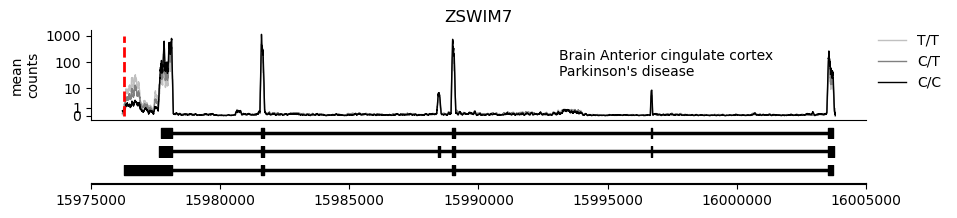

In [445]:
fig, axes = plt.subplots(nrows = 5, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1, 1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000214941, ax=axes[0])
plot_isoforms('ENSG00000214941', snmf_exons, [1, 3, 4], ax = axes[1:-1])

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000214941['coords'][0] - 1000
xlim2 = ENSG00000214941['coords'][-1] + 1000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('ZSWIM7')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
axes[0].text(xlim2-10000, 1.5, "Brain Anterior cingulate cortex\nParkinson's disease")
axes[0].set_yticks([np.log10(x+1) for x in [0, 1, 10, 100, 1000]])
axes[0].set_yticklabels([str(x) for x in [0, 1, 10, 100, 1000]])

plt.savefig('../code/scratch_figures/figure4/ENSG00000214941.ZSWIM7.BA24.Parkinsons.counts.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000214941.ZSWIM7.BA24.Parkinsons.counts.png', bbox_inches='tight', dpi=500)

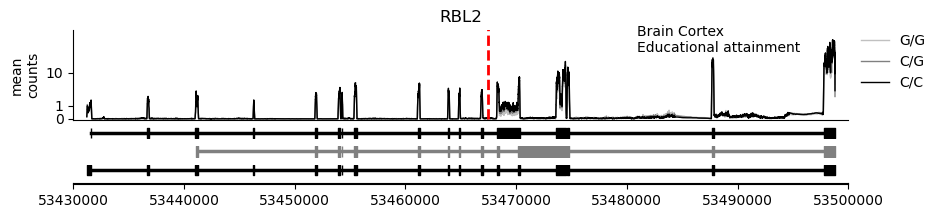

In [446]:


fig, axes = plt.subplots(nrows = 5, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1, 1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000103479, ax=axes[0], ylim=2)
plot_isoforms('ENSG00000103479', snmf_exons, [1, 2, 3], ax = axes[1:-1], colores=['black', 'gray', 'black'])

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000103479['coords'][0] - 1000
xlim2 = ENSG00000103479['coords'][-1] + 1000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('RBL2')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
axes[0].text(xlim2-16000, 1.5, "Brain Cortex\nEducational attainment")
axes[0].set_yticks([np.log10(x+1) for x in [0, 1, 10]])
axes[0].set_yticklabels([str(x) for x in [0, 1, 10]])

plt.savefig('../code/scratch_figures/figure4/ENSG00000103479.RBL2.BC.EduAttain.counts.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000103479.RBL2.BC.EduAttain.counts.png', bbox_inches='tight', dpi=500)

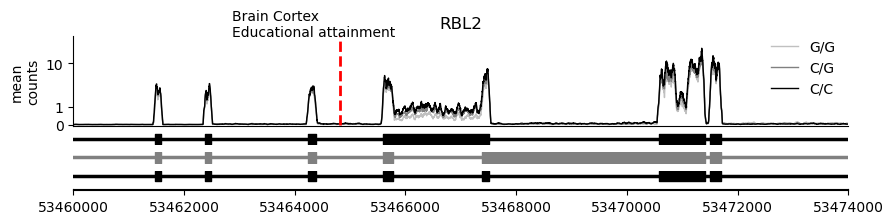

In [447]:


fig, axes = plt.subplots(nrows = 5, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1, 1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000103479, ax=axes[0], ylim=1.5)
plot_isoforms('ENSG00000103479', snmf_exons, [1, 2, 3], ax = axes[1:-1], colores=['black', 'gray', 'black'])

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000103479['coords'][0] + 26000
xlim2 = ENSG00000103479['coords'][-1] - 18000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('RBL2')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
axes[0].text(xlim2-10000, 1.5, "Brain Cortex\nEducational attainment")
axes[0].set_yticks([np.log10(x+1) for x in [0, 1, 10]])
axes[0].set_yticklabels([str(x) for x in [0, 1, 10]])

plt.savefig('../code/scratch_figures/figure4/ENSG00000103479.RBL2.BC.EduAttain.counts_zoom.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000103479.RBL2.BC.EduAttain.counts_zoom.png', bbox_inches='tight', dpi=500)

In [ ]:
plot_gene('ENSG00000103479', 'Brain_Cortex', 'chr16_53464743_C_G_b38', var_h = 2)

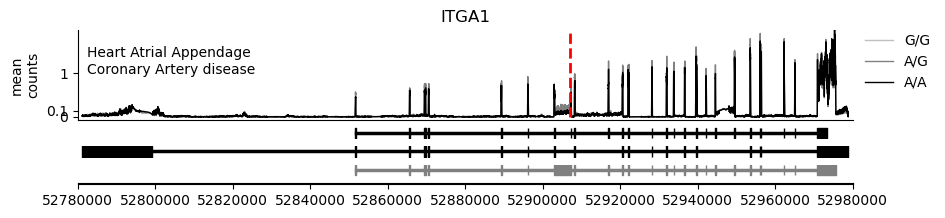

In [449]:
fig, axes = plt.subplots(nrows = 5, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1, 1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000213949, ax=axes[0], ylim=0.6)
plot_isoforms('ENSG00000213949', snmf_exons, [8, 3, 6], ax = axes[1:-1], colores=['black', 'black', 'gray'])

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000213949['coords'][0] - 1000
xlim2 = ENSG00000213949['coords'][-1] + 1000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('ITGA1')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
axes[0].text(xlim1+2000, 0.3, "Heart Atrial Appendage\nCoronary Artery disease")
axes[0].set_yticks([np.log10(x+1) for x in [0, 0.1, 1]])
axes[0].set_yticklabels([str(x) for x in [0, 0.1, 1]])

plt.savefig('../code/scratch_figures/figure4/ENSG00000213949.ITGA1.Heart.CAD.counts.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000213949.ITGA1.Heart.CAD.counts.png', bbox_inches='tight', dpi=500)

In [330]:
ENSG00000213949['var']

'chr5_52897294_A_G_b38'

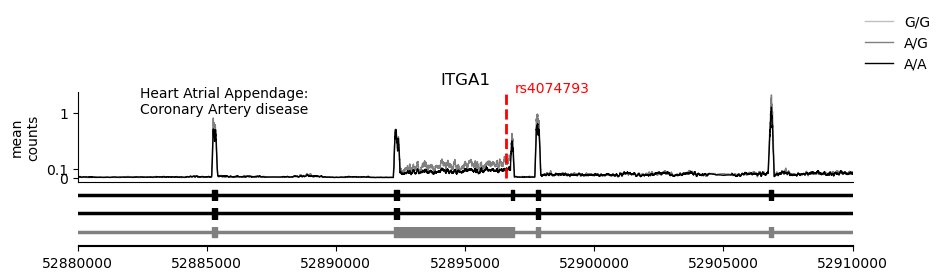

In [452]:
fig, axes = plt.subplots(nrows = 5, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1,1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000213949, ax=axes[0], ylim=0.4)
plot_isoforms('ENSG00000213949', snmf_exons, [8, 3, 6], ax = axes[1:-1], colores=['black', 'black', 'gray'])

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000213949['coords'][0] + 95000
xlim2 = ENSG00000213949['coords'][0] + 120000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('ITGA1')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
axes[0].text(xlim1+2000, 0.3, "Heart Atrial Appendage:\nCoronary Artery disease")
axes[0].text(xlim1+14100, 0.4, "rs4074793", c='red')

axes[0].set_yticks([np.log10(x+1) for x in [0, 0.1, 1]])
axes[0].set_yticklabels([str(x) for x in [0, 0.1, 1]])

plt.savefig('../code/scratch_figures/figure4/ENSG00000213949.ITGA1.Heart.CAD.counts_zoom.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000213949.ITGA1.Heart.CAD.counts_zoom.png', bbox_inches='tight', dpi=500)

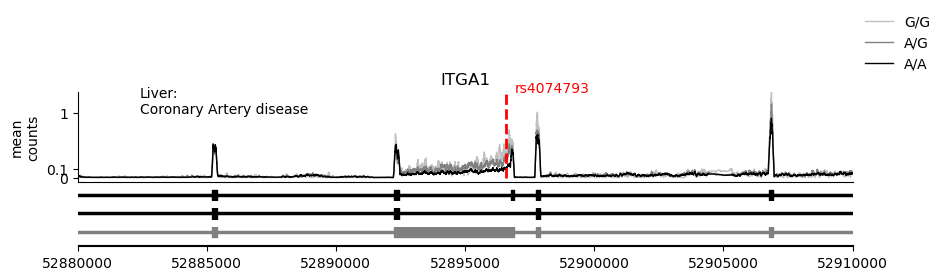

In [453]:
fig, axes = plt.subplots(nrows = 5, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1,1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000213949_liver, ax=axes[0], ylim=0.4)
plot_isoforms('ENSG00000213949', snmf_exons, [8, 3, 6], ax = axes[1:-1], colores=['black', 'black', 'gray'])

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000213949_liver['coords'][0] + 95000
xlim2 = ENSG00000213949_liver['coords'][0] + 120000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('ITGA1')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
axes[0].text(xlim1+2000, 0.3, "Liver:\nCoronary Artery disease")
axes[0].text(xlim1+14100, 0.4, "rs4074793", c='red')
axes[0].set_yticks([np.log10(x+1) for x in [0, 0.1, 1]])
axes[0].set_yticklabels([str(x) for x in [0, 0.1, 1]])

plt.savefig('../code/scratch_figures/figure4/ENSG00000213949.ITGA1.Liver.CAD.counts_zoom.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000213949.ITGA1.Liver.CAD.counts_zoom.png', bbox_inches='tight', dpi=500)

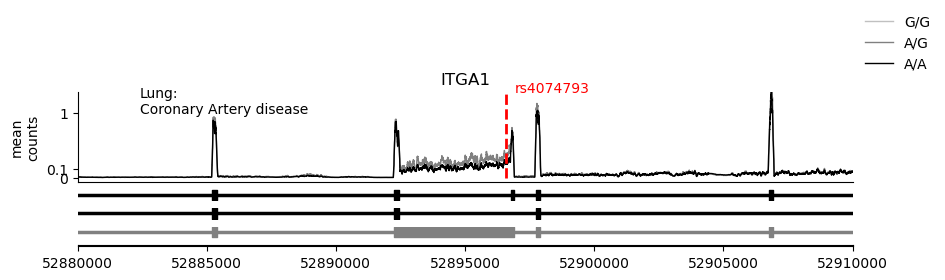

In [454]:
fig, axes = plt.subplots(nrows = 5, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1,1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000213949_lung, ax=axes[0], ylim=0.4)
plot_isoforms('ENSG00000213949', snmf_exons, [8, 3, 6], ax = axes[1:-1], colores=['black', 'black', 'gray'])

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000213949_lung['coords'][0] + 95000
xlim2 = ENSG00000213949_lung['coords'][0] + 120000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('ITGA1')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
axes[0].text(xlim1+2000, 0.3, "Lung:\nCoronary Artery disease")
axes[0].text(xlim1+14100, 0.4, "rs4074793", c='red')
axes[0].set_yticks([np.log10(x+1) for x in [0, 0.1, 1]])
axes[0].set_yticklabels([str(x) for x in [0, 0.1, 1]])

plt.savefig('../code/scratch_figures/figure4/ENSG00000213949.ITGA1.Lung.CAD.counts_zoom.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000213949.ITGA1.Lung.CAD.counts_zoom.png', bbox_inches='tight', dpi=500)

In [11]:
cad_var = get_snp_record(gtex_vcf, 'chr5_52897294_A_G_b38')

In [12]:
cad_var.num_hom_ref

740

In [13]:
var_id = 'chr5_52897294_A_G_b38'

In [157]:
counts = pd.read_csv(f'../code/coverage/counts_filtered/ENSG00000213949.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Liver' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]

var_parts = 'chr5_52897294_A_G_b38'.split('_')
var_loc = int(var_parts[1])
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

In [159]:
np.log10(counts_ba9.sum(axis=1)).loc[hom_refs].mean()

3.914103782172892

In [161]:
np.log10(counts_ba9.sum(axis=1)).loc[hets].mean()

3.918285639680384

In [17]:
len(hom_alts.intersection(liver_qqnorm.columns))

1

In [18]:
len(hets.intersection(liver_qqnorm.columns))

13

In [19]:
liver_qqnorm = pd.read_csv('../code/QTLs/GTEx_10/Liver/transcripts_10.sorted.qqnorm.bed.gz', sep='\t', index_col=3)

In [20]:
boxplot_df = pd.DataFrame()
aa_norm = list(liver_qqnorm.loc['ENSG00000213949.isoform_8', hom_refs.intersection(liver_qqnorm.columns)])
ag_norm = list(liver_qqnorm.loc['ENSG00000213949.isoform_8', hets.intersection(liver_qqnorm.columns)])
gg_norm = list(liver_qqnorm.loc['ENSG00000213949.isoform_8', hom_alts.intersection(liver_qqnorm.columns)])

norm_list = aa_norm + ag_norm + gg_norm

genotype = ['A/A']*len( hom_refs.intersection(liver_qqnorm.columns))
genotype += ['A/G']*len( hets.intersection(liver_qqnorm.columns))
genotype += ['G/G']*len( hom_alts.intersection(liver_qqnorm.columns))

boxplot_df['genotype'] = genotype
boxplot_df['isoform_8'] = norm_list

{'whiskers': [<matplotlib.lines.Line2D at 0x7f133d204a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f133d204d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f133d2047f0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f133d2052d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f133d205570>,
 'means': []}

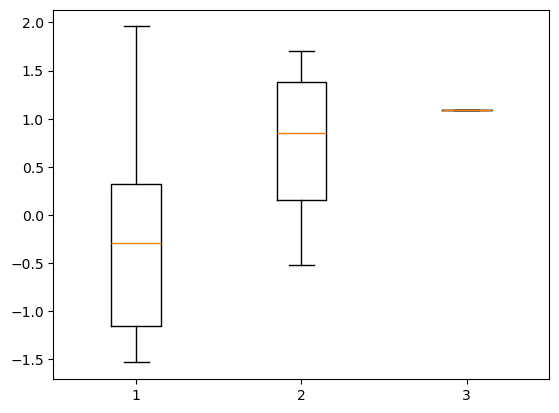

In [21]:
plt.boxplot([aa_norm, ag_norm, gg_norm])

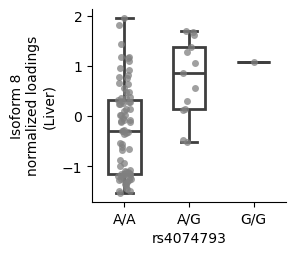

In [22]:

plt.figure(figsize=(2.5, 2.5))




ax = sns.boxplot(data = boxplot_df, x = 'genotype', y= 'isoform_8', width=.5, fliersize=0, linewidth=2,patch_artist=True, 
                 boxprops=dict(facecolor='white'))
ax.set_ylabel('Isoform 8\nnormalized loadings\n(Liver)')
    


ax.spines[['top', 'right']].set_visible(False)
# ax.set_xticklabels(['same', 'opposite'])
# ax.tick_params(size=4, width=2, labelsize=14)
# sns.despine(offset=5, trim=True)

sns.stripplot(data = boxplot_df, x = 'genotype', y= 'isoform_8', c='gray', alpha=0.75)
ax.set_xlabel('rs4074793')

plt.savefig('../code/scratch_figures/figure4/ITGA1.Liver.boxplot.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ITGA1.Liver.boxplot.png', bbox_inches='tight', dpi=500)

In [59]:
cad_var = get_snp_record(gtex_vcf, 'chr5_52897294_A_G_b38')

In [60]:
counts = pd.read_csv(f'../code/coverage/counts_filtered/ENSG00000140988.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Heart_Atrial_Appendage' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]

var_parts = 'chr5_52897294_A_G_b38'.split('_')
var_loc = int(var_parts[1])
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

In [61]:
liver_qqnorm = pd.read_csv('../code/QTLs/GTEx_10/Heart_Atrial_Appendage/transcripts_10.sorted.qqnorm.bed.gz', sep='\t', index_col=3)
boxplot_df = pd.DataFrame()
aa_norm = list(liver_qqnorm.loc['ENSG00000213949.isoform_8', hom_refs.intersection(liver_qqnorm.columns)])
ag_norm = list(liver_qqnorm.loc['ENSG00000213949.isoform_8', hets.intersection(liver_qqnorm.columns)])
gg_norm = list(liver_qqnorm.loc['ENSG00000213949.isoform_8', hom_alts.intersection(liver_qqnorm.columns)])

norm_list = aa_norm + ag_norm + gg_norm

genotype = ['A/A']*len( hom_refs.intersection(liver_qqnorm.columns))
genotype += ['A/G']*len( hets.intersection(liver_qqnorm.columns))
genotype += ['G/G']*len( hom_alts.intersection(liver_qqnorm.columns))

boxplot_df['genotype'] = genotype
boxplot_df['isoform_8'] = norm_list

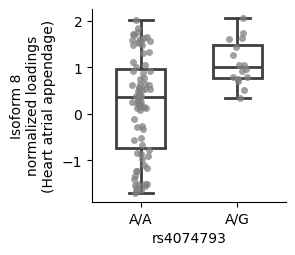

In [63]:

plt.figure(figsize=(2.5, 2.5))




ax = sns.boxplot(data = boxplot_df, x = 'genotype', y= 'isoform_8', width=.5, fliersize=0, linewidth=2,patch_artist=True, 
                 boxprops=dict(facecolor='white'))
ax.set_ylabel('Isoform 8\nnormalized loadings\n(Heart atrial appendage)')
    


ax.spines[['top', 'right']].set_visible(False)
# ax.set_xticklabels(['same', 'opposite'])
# ax.tick_params(size=4, width=2, labelsize=14)
# sns.despine(offset=5, trim=True)

sns.stripplot(data = boxplot_df, x = 'genotype', y= 'isoform_8', c='gray', alpha=0.75)
ax.set_xlabel('rs4074793')

plt.savefig('../code/scratch_figures/figure4/ITGA1.Heart_atrial_appendage.boxplot.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ITGA1.Heart_atrial_appendage.boxplot.png', bbox_inches='tight', dpi=500)

In [64]:
counts = pd.read_csv(f'../code/coverage/counts_filtered/ENSG00000140988.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Lung' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]

var_parts = 'chr5_52897294_A_G_b38'.split('_')
var_loc = int(var_parts[1])
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

In [ ]:
liver_qqnorm = pd.read_csv('../code/QTLs/GTEx_10/Lung/transcripts_10.sorted.qqnorm.bed.gz', sep='\t', index_col=3)
boxplot_df = pd.DataFrame()
aa_norm = list(liver_qqnorm.loc['ENSG00000213949.isoform_8', hom_refs.intersection(liver_qqnorm.columns)])
ag_norm = list(liver_qqnorm.loc['ENSG00000213949.isoform_8', hets.intersection(liver_qqnorm.columns)])
gg_norm = list(liver_qqnorm.loc['ENSG00000213949.isoform_8', hom_alts.intersection(liver_qqnorm.columns)])

norm_list = aa_norm + ag_norm + gg_norm

genotype = ['A/A']*len( hom_refs.intersection(liver_qqnorm.columns))
genotype += ['A/G']*len( hets.intersection(liver_qqnorm.columns))
genotype += ['G/G']*len( hom_alts.intersection(liver_qqnorm.columns))

boxplot_df['genotype'] = genotype
boxplot_df['isoform_8'] = norm_list

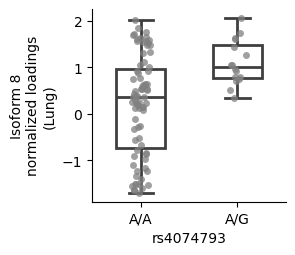

In [65]:

plt.figure(figsize=(2.5, 2.5))




ax = sns.boxplot(data = boxplot_df, x = 'genotype', y= 'isoform_8', width=.5, fliersize=0, linewidth=2,patch_artist=True, 
                 boxprops=dict(facecolor='white'))
ax.set_ylabel('Isoform 8\nnormalized loadings\n(Lung)')
    


ax.spines[['top', 'right']].set_visible(False)
# ax.set_xticklabels(['same', 'opposite'])
# ax.tick_params(size=4, width=2, labelsize=14)
# sns.despine(offset=5, trim=True)

sns.stripplot(data = boxplot_df, x = 'genotype', y= 'isoform_8', c='gray', alpha=0.75)
ax.set_xlabel('rs4074793')

plt.savefig('../code/scratch_figures/figure4/ITGA1.Lung.boxplot.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ITGA1.Lung.boxplot.png', bbox_inches='tight', dpi=500)

In [70]:
qtls = pd.read_csv(f'../code/QTLs/GTEx_10/Lung/transcripts_10.PermutationPass.FDR_Added.txt.gz', sep=' ')
qtls['gene'] = qtls.phe_id.apply(lambda x: x.split('.')[0])
qtls = qtls.set_index('phe_id')

In [71]:
qtls.loc['ENSG00000213949.isoform_8']

phe_chr                           chr5
phe_from                      52788465
phe_to                        52959258
phe_strd                             +
n_var_in_cis                      4242
dist_phe_var                         0
var_id           chr5_52897406_A_G_b38
var_chr                           chr5
var_from                      52897406
var_to                        52897406
dof1                                95
dof2                           188.423
bml1                          0.633394
bml2                          456350.0
nom_pval                           0.0
r_squared                     0.315611
slope                         0.751601
slope_se                      0.113554
adj_emp_pval                  0.000999
adj_beta_pval                      0.0
q                             0.000004
gene                   ENSG00000213949
Name: ENSG00000213949.isoform_8, dtype: object

In [77]:
samples = pd.read_csv('../code/config/samples.tsv', sep='\t', index_col=0)

tissues = sorted(['Brain_Anterior_cingulate_cortex_BA24',
 'Brain_Cortex',
 'Brain_Frontal_Cortex_BA9',
 'Brain_Putamen_basal_ganglia',
           'Skin_Not_Sun_Exposed_Suprapubic',
           'Liver',
 'Lung', 'Heart_Atrial_Appendage', 'Muscle_Skeletal','Whole_Blood'
          ])


In [73]:
tpm_fh = gzip.open('../code/gtex_tables/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz', 'r')
tpm_fh.readline()
tpm_fh.readline()
tpm_columns = tpm_fh.readline().decode().rstrip().split('\t')

In [74]:
pkm = 'ENSG00000213949'
for linea in tpm_fh:
    linea = linea.decode().rstrip().split('\t')
    if linea[0].startswith(pkm):
        break

In [80]:
counts = pd.read_csv(f'../code/coverage/counts_filtered/ENSG00000140988.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Liver' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]

var_parts = 'chr5_52897294_A_G_b38'.split('_')
var_loc = int(var_parts[1])
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

liver_qqnorm = pd.read_csv('../code/QTLs/GTEx_10/Liver/transcripts_10.sorted.qqnorm.bed.gz', sep='\t', index_col=3)


In [110]:
transcript_EL = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/transcript.merged_isoforms.EL.bed.gz', sep='\t', index_col=3)

wb_samples = samples.loc[samples.tissue_id == 'Liver'].index.intersection(transcript_EL.columns)
tpm_wb_samples = [x in wb_samples for x in tpm_columns]

pkm_tpm_wb = [float(x) for x in np.array(linea)[tpm_wb_samples]]
tpm_wb_order = []
for i, idx in enumerate(tpm_wb_samples):
    if idx:
        tpm_wb_order.append(tpm_columns[i])

In [111]:
tpm_liver = pd.DataFrame()
tpm_liver['sample_id'] = tpm_wb_order
tpm_liver['sample'] = ['-'.join(x.split('-')[:2]) for x in tpm_wb_order]
tpm_liver['tpm'] = pkm_tpm_wb

In [112]:
tpm_liver = tpm_liver.set_index('sample')

In [113]:
counts = pd.read_csv(f'../code/coverage/counts_filtered/ENSG00000140988.csv.gz', index_col=0)
counts_ba9 = counts.loc[[x for x in counts.index if 'Liver' in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]

var_parts = 'chr5_52897294_A_G_b38'.split('_')
var_loc = int(var_parts[1])
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)


boxplot_df = pd.DataFrame()
aa_norm = list(tpm_liver.loc[hom_refs.intersection(tpm_liver.index), 'tpm'])
ag_norm = list(tpm_liver.loc[hets.intersection(tpm_liver.index), 'tpm'])
gg_norm = list(tpm_liver.loc[hom_alts.intersection(tpm_liver.index), 'tpm'])

norm_list = aa_norm + ag_norm + gg_norm

genotype = ['A/A']*len( hom_refs.intersection(tpm_liver.index))
genotype += ['A/G']*len( hets.intersection(tpm_liver.index))
genotype += ['G/G']*len( hom_alts.intersection(tpm_liver.index))

boxplot_df['genotype'] = genotype
boxplot_df['ITGA1'] = norm_list

{'whiskers': [<matplotlib.lines.Line2D at 0x7f133c73ca60>,
 'caps': [<matplotlib.lines.Line2D at 0x7f133c73d630>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1268183fd0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f133c73c3a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f133c73f700>,
 'means': []}

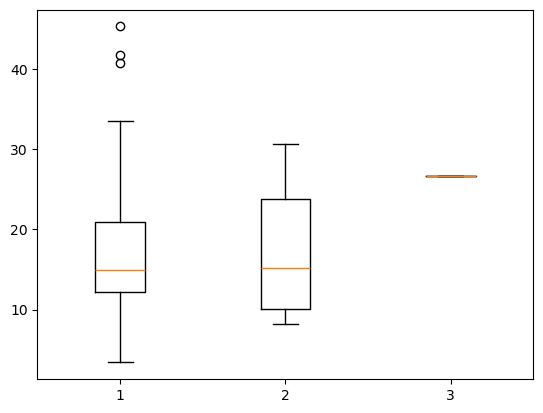

In [114]:
plt.boxplot([aa_norm, ag_norm, gg_norm])

In [144]:
fh = gzip.open("../code/gtex_tables/GTEx_Analysis_v8_eQTL_expression_matrices/Esophagus_Muscularis.v8.normalized_expression.bed.gz", 'rb')
col_names = fh.readline().decode().rstrip().split('\t')

In [145]:
import pysam 
tbx = pysam.TabixFile("../code/gtex_tables/GTEx_Analysis_v8_eQTL_expression_matrices/Esophagus_Muscularis.v8.normalized_expression.bed.gz")

# Define the region to query (e.g., chromosome 1, from position 1000 to 2000)
region = "chr5:52777916-52960209"

# Iterate through the records in the specified region
genes = []
for record in tbx.fetch(region=region):
    genes.append(record.rstrip().split('\t'))

[W::hts_idx_load3] The index file is older than the data file: ../code/gtex_tables/GTEx_Analysis_v8_eQTL_expression_matrices/Esophagus_Muscularis.v8.normalized_expression.bed.gz.tbi


In [146]:
tpm_df = pd.DataFrame()
tpm_df['col_names'] = col_names
for g in genes:
    gene_name = g[3].split('.')[0]
    tpm_df[gene_name] = g


In [147]:
tpm_df = tpm_df.set_index('col_names')
tpm_df = tpm_df.iloc[4:]
tpm_df['ENSG00000213949'] = tpm_df.ENSG00000213949.astype(float)

In [148]:
# counts = pd.read_csv(f'../code/coverage/counts_filtered/ENSG00000140988.csv.gz', index_col=0)
# counts_ba9 = counts.loc[[x for x in counts.index if 'Lung' in x]]
# counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]

var_parts = 'chr5_52897294_A_G_b38'.split('_')
var_loc = int(var_parts[1])
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(tpm_df.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(tpm_df.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(tpm_df.index)

In [151]:
tpm_df.loc[hom_alts, 'ENSG00000213949'].mean()

1.2459684729558944

In [386]:
liver_qqnorm.loc['ENSG00000213949.isoform_8', hets.intersection(liver_qqnorm.columns)].mean()

0.7449848350548726

In [385]:
liver_qqnorm.loc['ENSG00000213949.isoform_8', hom_alts.intersection(liver_qqnorm.columns)]

GTEX-144GM    1.085557
Name: ENSG00000213949.isoform_8, dtype: object

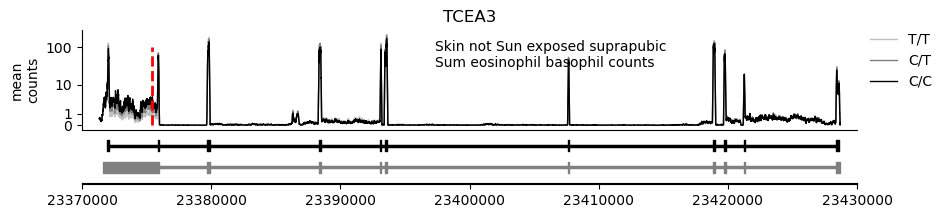

In [478]:
fig, axes = plt.subplots(nrows = 4, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000204219, ax=axes[0], var_h=2)
plot_isoforms('ENSG00000204219', snmf_exons, [1, 7], ax = axes[1:-1], colores = ['black', 'gray'])

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000204219['coords'][0] - 1000
xlim2 = ENSG00000204219['coords'][-1] + 1000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('TCEA3')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
axes[0].text(xlim2-25000, 1.5, "Skin not Sun exposed suprapubic\nSum eosinophil basophil counts")
axes[0].set_yticks([np.log10(x+1) for x in [0, 1, 10, 100]])
axes[0].set_yticklabels([str(x) for x in [0, 1, 10, 100]])

plt.savefig('../code/scratch_figures/figure4/ENSG00000204219.TCEA3.Skin.Basophil.counts.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000204219.TCEA3.Skin.Basophil.counts.png', bbox_inches='tight', dpi=500)

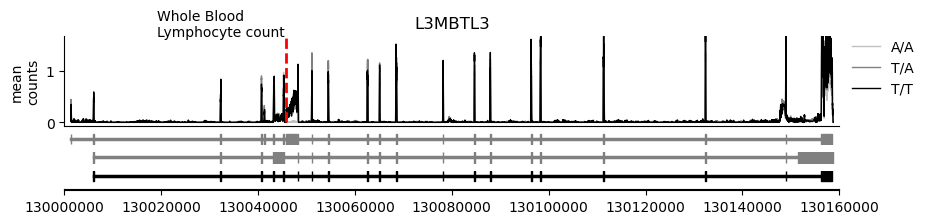

In [477]:
fig, axes = plt.subplots(nrows = 5, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1,1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000198945, ax=axes[0], ylim=0.5, var_h = 1)
plot_isoforms('ENSG00000198945', snmf_exons, [5, 3, 4], ax = axes[1:-1], colores = ['gray', 'gray', 'black'])

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000198945['coords'][0] - 1000
xlim2 = ENSG00000198945['coords'][-1] + 1000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('L3MBTL3')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
axes[0].text(xlim1+15000, 0.5, "Whole Blood\nLymphocyte count")
axes[0].set_yticks([np.log10(x+1) for x in [0, 1]])
axes[0].set_yticklabels([str(x) for x in [0, 1]])

plt.savefig('../code/scratch_figures/figure4/ENSG00000198945.L3MBTL3.WB.Lymphocyte.counts.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000198945.L3MBTL3.WB.Lymphocyte.counts.png', bbox_inches='tight', dpi=500)

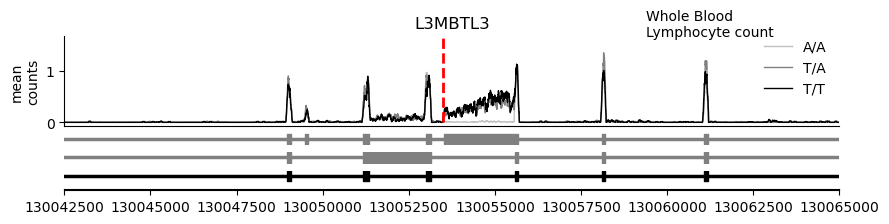

In [467]:
fig, axes = plt.subplots(nrows = 5, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1,1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000198945, ax=axes[0], ylim=0.5, var_h = 1)
plot_isoforms('ENSG00000198945', snmf_exons, [5, 3, 4], ax = axes[1:-1], colores = ['gray', 'gray', 'black'])

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000198945['coords'][0] + 25000
xlim2 = ENSG00000198945['coords'][0] + 45000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('L3MBTL3')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
axes[0].text(xlim1+15000, 0.5, "Whole Blood\nLymphocyte count")
axes[0].set_yticks([np.log10(x+1) for x in [0, 1]])
axes[0].set_yticklabels([str(x) for x in [0, 1]])

plt.savefig('../code/scratch_figures/figure4/ENSG00000198945.L3MBTL3.WB.Lymphocyte.counts_zoom.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000198945.L3MBTL3.WB.Lymphocyte.counts_zoom.png', bbox_inches='tight', dpi=500)

In [439]:
lc_var = get_snp_record(gtex_vcf, 'chr6_130053316_T_A_b38')

In [443]:
len(lc_var.get_hom_alts())

504

In [188]:
snmf_exons

,chrom,start,end,gene_id,transcript_id,strand,factors,exon_id
0,chr1,923874,944151,ENSG00000187634,ENSG00000187634.isoform_1,+,factor_1:factor_3:factor_4:factor_5:factor_6:f...,exon_1
1,chr1,924423,924948,ENSG00000187634,ENSG00000187634.isoform_4,+,factor_9,exon_1
2,chr1,924630,924948,ENSG00000187634,ENSG00000187634.isoform_3,+,factor_7,exon_1
3,chr1,925922,926013,ENSG00000187634,ENSG00000187634.isoform_4,+,factor_9,exon_2
4,chr1,925922,926013,ENSG00000187634,ENSG00000187634.isoform_3,+,factor_7,exon_2
...,...,...,...,...,...,...,...,...
763813,chrX,156025241,156025422,ENSG00000182484,ENSG00000182484.isoform_6,+,factor_5,exon_5
763814,chrX,156025241,156025292,ENSG00000182484,ENSG00000182484.isoform_2,+,factor_10,exon_7
763815,chrX,156025241,156025422,ENSG00000182484,ENSG00000182484.isoform_5,+,factor_4:factor_9,exon_7
763816,chrX,156025241,156025301,ENSG00000182484,ENSG00000182484.isoform_3,+,factor_2,exon_7


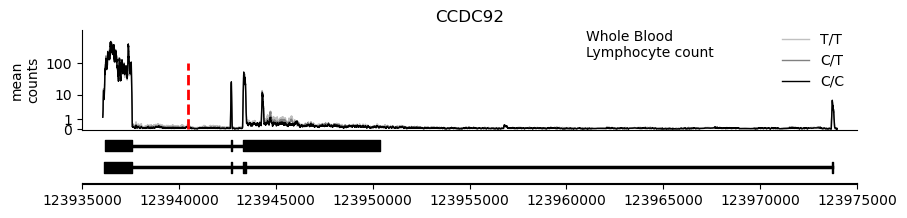

In [492]:
# plot_gene('ENSG00000119242', 'Heart_Atrial_Appendage', 'chr12_123940602_C_T_b38', var_h = 2)

fig, axes = plt.subplots(nrows = 4, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000119242, ax=axes[0], ylim=3, var_h = 2)
plot_isoforms('ENSG00000119242', snmf_exons, [1, 3], ax = axes[1:-1], )

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000119242['coords'][0] - 1000
xlim2 = ENSG00000119242['coords'][-1] + 1000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('CCDC92')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
axes[0].text(xlim1+25000, 2.2, "Whole Blood\nLymphocyte count")
axes[0].set_yticks([np.log10(x+1) for x in [0, 1, 10, 100]])
axes[0].set_yticklabels([str(x) for x in [0, 1, 10, 100]])

plt.savefig('../code/scratch_figures/figure4/ENSG00000119242.CCDC92.WB.Lymphocyte.counts.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000119242.CCDC92.WB.Lymphocyte.counts.png', bbox_inches='tight', dpi=500)

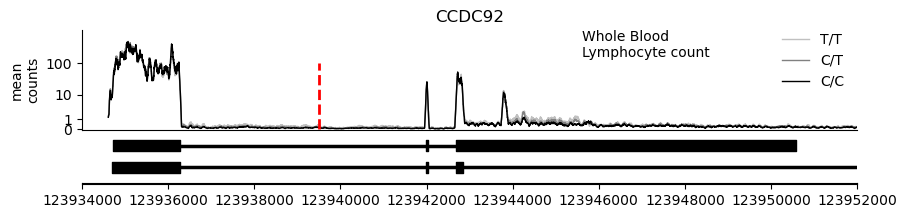

In [494]:
# plot_gene('ENSG00000119242', 'Heart_Atrial_Appendage', 'chr12_123940602_C_T_b38', var_h = 2)

fig, axes = plt.subplots(nrows = 4, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000119242, ax=axes[0], ylim=3, var_h = 2)
plot_isoforms('ENSG00000119242', snmf_exons, [1, 3], ax = axes[1:-1], )

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000119242['coords'][0] - 500
xlim2 = ENSG00000119242['coords'][0] + 15000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('CCDC92')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
# axes[0].text(xlim1+15000, 0.5, "Whole Blood\nLymphocyte count")
axes[0].set_yticks([np.log10(x+1) for x in [0, 1, 10, 100]])
axes[0].set_yticklabels([str(x) for x in [0, 1, 10, 100]])
axes[0].text(xlim1+10000, 2.2, "Whole Blood\nLymphocyte count")


plt.savefig('../code/scratch_figures/figure4/ENSG00000119242.CCDC92.WB.Lymphocyte.counts_zoom.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000119242.CCDC92.WB.Lymphocyte.counts_zoom.png', bbox_inches='tight', dpi=500)

39776957
39655612


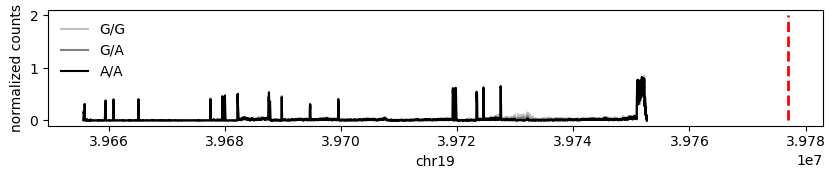

In [104]:
# plot_gene('ENSG00000119242', 'Heart_Atrial_Appendage', 'chr12_123940602_C_T_b38', var_h = 2)

fig, axes = plt.subplots(nrows = 5, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1,1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000119242, ax=axes[0], ylim=3, var_h = 1)
plot_isoforms('ENSG00000119242', snmf_exons, [1, 3, 4], ax = axes[1:-1], )

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000119242['coords'][0] - 1000
xlim2 = ENSG00000119242['coords'][-1] + 1000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('CCDC92')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
# axes[0].text(xlim1+15000, 0.5, "Whole Blood\nLymphocyte count")
axes[0].set_yticks([np.log10(x+1) for x in [0, 1]])
axes[0].set_yticklabels([str(x) for x in [0, 1]])

plt.savefig('../code/scratch_figures/figure4/ENSG00000119242.CCDC92.WB.Lymphocyte.counts_zoom.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000119242.CCDC92.WB.Lymphocyte.counts_zoom.png', bbox_inches='tight', dpi=500)

In [119]:
39776957 - 39655612

121345

39776957
39655612


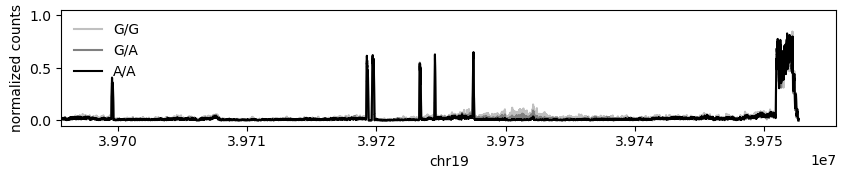

In [120]:
plot_gene('ENSG00000133103', 'Skin_Not_Sun_Exposed_Suprapubic', 'chr13_39776957_T_G_b38', var_h = 1, xlim1=40000, xlim2=100000)

6416460
6409079


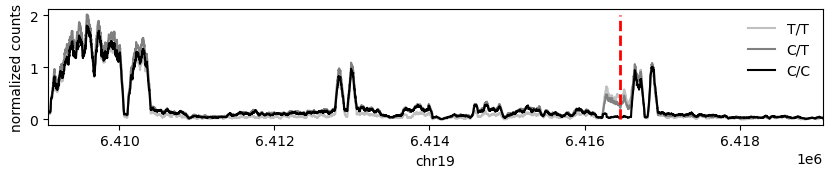

In [145]:
plot_gene('ENSG00000164535', 'Whole_Blood', 'chr7_6416460_C_T_b38',  xlim1=1, xlim2=10000, var_h = 2)

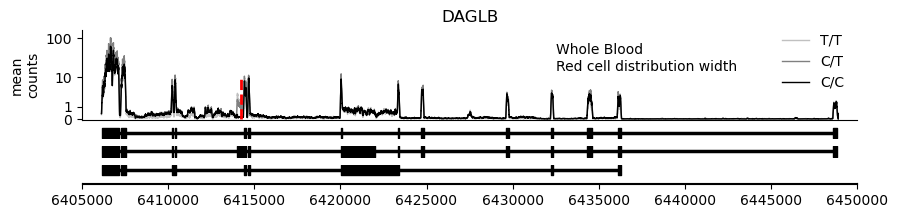

In [498]:
# plot_gene('ENSG00000164535', 'Whole_Blood', 'chr7_6416460_C_T_b38', var_h = 2)

fig, axes = plt.subplots(nrows = 5, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1,1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000164535, ax=axes[0], ylim=2.2, var_h = 1)
plot_isoforms('ENSG00000164535', snmf_exons, [1, 3, 4], ax = axes[1:-1], )

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000164535['coords'][0] - 1000
xlim2 = ENSG00000164535['coords'][-1] + 1000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('DAGLB')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
# axes[0].text(xlim1+15000, 0.5, "Whole Blood\nLymphocyte count")
axes[0].set_yticks([np.log10(x+1) for x in [0, 1, 10, 100]])
axes[0].set_yticklabels([str(x) for x in [0, 1, 10, 100]])
axes[0].text(xlim1+25000, 1.2, "Whole Blood\nRed cell distribution width")


plt.savefig('../code/scratch_figures/figure4/ENSG00000164535.DAGLB.WB.Redcell.counts.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000164535.DAGLB.WB.Redcell.counts.png', bbox_inches='tight', dpi=500)

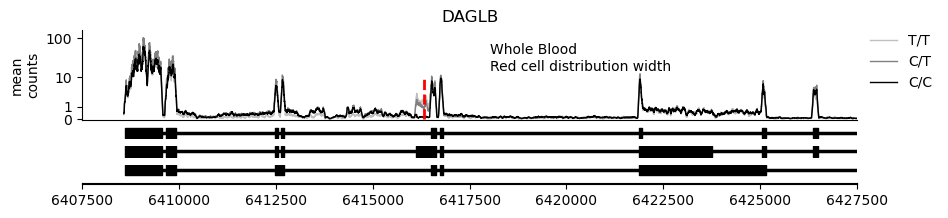

In [500]:
# plot_gene('ENSG00000164535', 'Whole_Blood', 'chr7_6416460_C_T_b38', var_h = 2)

fig, axes = plt.subplots(nrows = 5, figsize = (10, 2), gridspec_kw={'height_ratios': [8, 1, 1,1, 0.1], 'hspace': 0.3})
plot_gene_counts(ENSG00000164535, ax=axes[0], ylim=2.2, var_h = 1)
plot_isoforms('ENSG00000164535', snmf_exons, [1, 3, 4], ax = axes[1:-1], )

axes[0].spines[['top', 'right']].set_visible(False)

xlim1 = ENSG00000164535['coords'][0] - 1000
xlim2 = ENSG00000164535['coords'][0] + 18000
for ax in axes:
    ax.set_xlim([xlim1, xlim2])

axes[0].set_title('DAGLB')

axes[-1].set_yticks([])
xticks = axes[-1].get_xticks()
axes[-1].set_xticks(xticks)
xtick_labels = [str(int(x)) for x in xticks]
axes[-1].set_xticklabels(xtick_labels)
# axes[0].text(xlim1+15000, 0.5, "Whole Blood\nLymphocyte count")
axes[0].set_yticks([np.log10(x+1) for x in [0, 1, 10, 100]])
axes[0].set_yticklabels([str(x) for x in [0, 1, 10, 100]])
axes[0].text(xlim1+10000, 1.2, "Whole Blood\nRed cell distribution width")


plt.savefig('../code/scratch_figures/figure4/ENSG00000164535.DAGLB.WB.Redcell.counts_zoom.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure4/ENSG00000164535.DAGLB.WB.Redcell.counts_zoom.png', bbox_inches='tight', dpi=500)

130053316
130018539


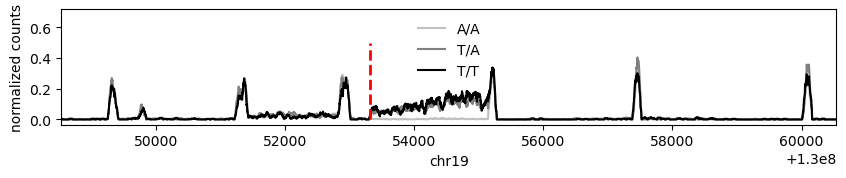

In [147]:
plot_gene('ENSG00000198945', 'Whole_Blood', 'chr6_130053316_T_A_b38', var_h=0.5, xlim1 =30000, xlim2=42000)

130053316
130018539


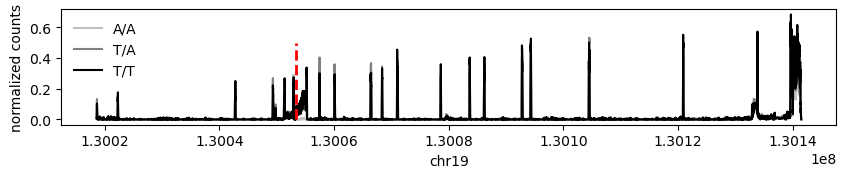

In [148]:
plot_gene('ENSG00000198945', 'Whole_Blood', 'chr6_130053316_T_A_b38', var_h=0.5)

52897294
52788464


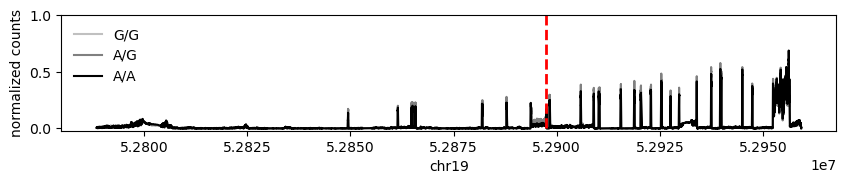

In [152]:
plot_gene('ENSG00000213949', 'Heart_Atrial_Appendage', 'chr5_52897294_A_G_b38', ylim=1, var_h=1)

In [153]:
52897294 - 52788464

108830

52897294
52788464


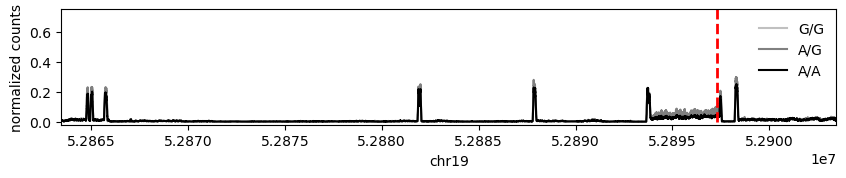

In [155]:
mean_counts_1, mean_counts_2, mean_counts_3, x_cols = plot_gene(
    'ENSG00000213949', 'Heart_Atrial_Appendage', 'chr5_52897294_A_G_b38', ylim=0.75, var_h=1, xlim1=75000, xlim2=115000)

In [158]:
mean_counts_1

array([nan, nan, nan, ..., nan, nan, nan])

23383982
23380859


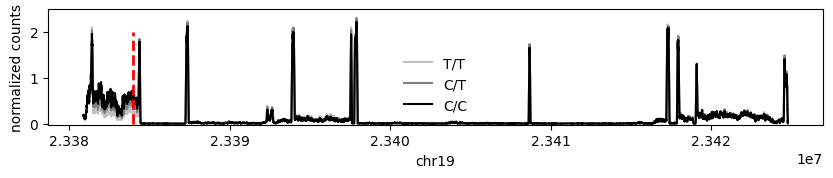

In [140]:
plot_gene('ENSG00000204219', 'Skin_Not_Sun_Exposed_Suprapubic', 'chr1_23383982_C_T_b38', ylim=2.5, var_h=2)

23383982
23380859


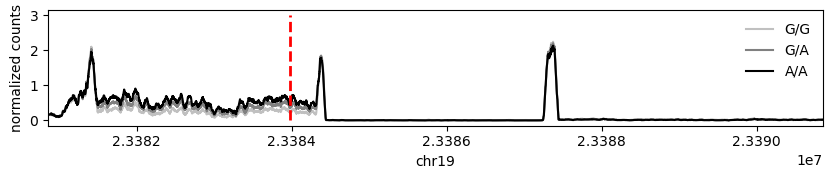

In [138]:
plot_gene('ENSG00000204219', 'Skin_Not_Sun_Exposed_Suprapubic', 'chr1_23383982_C_T_b38', xlim1=1, xlim2=10000)

23383982
23380859


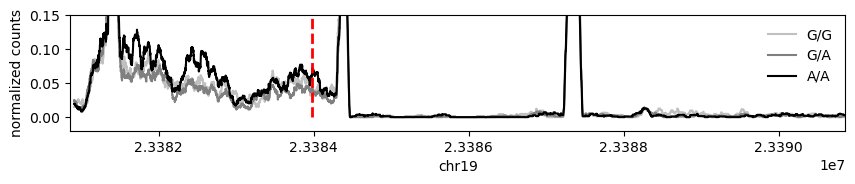

In [137]:
plot_gene('ENSG00000204219', 'Whole_Blood', 'chr1_23383982_C_T_b38', ylim=0.15, xlim1=1, xlim2=10000, smooth=100)

66557112
66563414


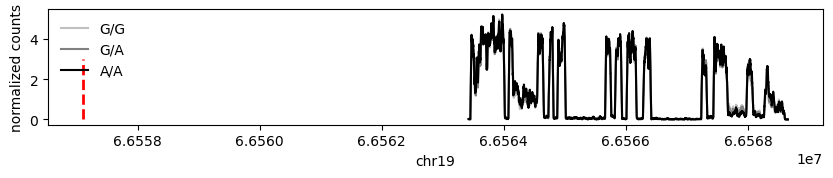

In [105]:
plot_gene('ENSG00000174080', 'Brain_Anterior_cingulate_cortex_BA24', 'chr11_66557112_T_C_b38', smooth=20)

1964282
1961858


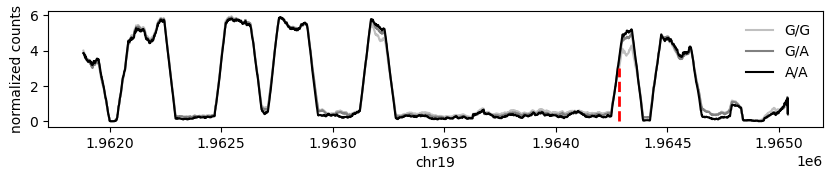

In [106]:
plot_gene('ENSG00000140988', 'Heart_Atrial_Appendage', 'chr16_1964282_A_G_b38', counts = 'whole_gene')

142130032
142108729


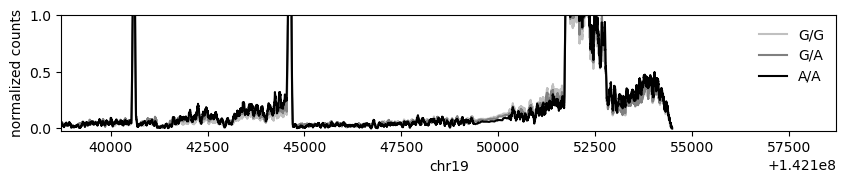

In [113]:
plot_gene('ENSG00000131507', 'Whole_Blood', 'chr5_142130032_G_A_b38', xlim1 = 30000, xlim2=50000, ylim = 1)

142130032
142108729


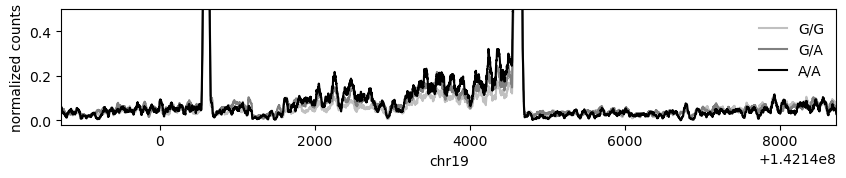

In [115]:
plot_gene('ENSG00000131507', 'Whole_Blood', 'chr5_142130032_G_A_b38', xlim1 = 30000, xlim2=40000, ylim = 0.5)

In [ ]:
plot_gene('ENSG00000131507', 'Whole_Blood', 'chr5_142130032_G_A_b38', xlim1 = 30000, xlim2=40000, ylim = 0.5)

In [101]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000172890.csv.gz', index_col=0)


'chr11:71453153'

123135291
122983430


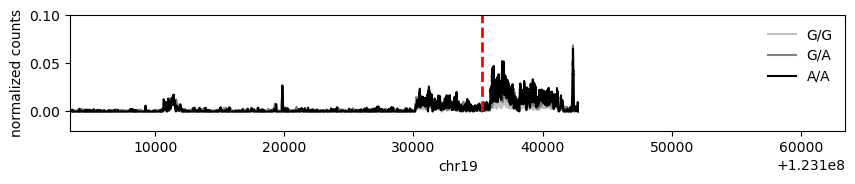

In [21]:
plot_gene('ENSG00000090975', 'Brain_Anterior_cingulate_cortex_BA24', 'chr12_123135291_G_A_b38', var_h = 0.5, ylim=0.1, 
         xlim1 = 120000, xlim2 = 180000)

48955847
48954825


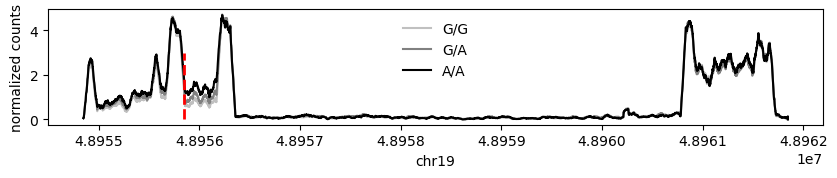

In [118]:
plot_gene('ENSG00000087088', 'Whole_Blood', 'chr19_48955847_A_G_b38', smooth=50)

49660026
49683747


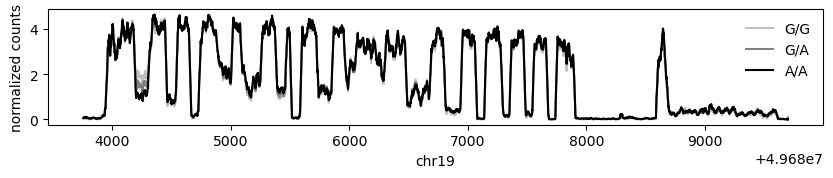

In [127]:
plot_gene('ENSG00000173531', 'Liver', 'chr3_49660026_G_A_b38', plot_var=False, smooth=20, counts = 'whole_gene')

In [54]:
# counts = pd.read_csv(f'../code/coverage/counts_filtered/ENSG00000090975.csv.gz', index_col=0)
tissue = 'Brain_Anterior_cingulate_cortex_BA24'
var_id = 'chr12_123135291_G_A_b38'
counts_ba9 = counts.loc[[x for x in counts.index if tissue in x]]
counts_ba9.index = ['-'.join(x.split('-')[:2]) for x in counts_ba9.index]



# var_id = 'chr12_123940602_C_T_b38'
var_loc = int(var_id.split('_')[1])
rec_ = get_snp_record(gtex_vcf, var_id)
ref = rec_.REF
alt = str(rec_.ALT[0])
hom_refs = pd.Index([x.sample for x in rec_.get_hom_refs()]).intersection(counts_ba9.index)
hets = pd.Index([x.sample for x in rec_.get_hets()]).intersection(counts_ba9.index)
hom_alts = pd.Index([x.sample for x in rec_.get_hom_alts()]).intersection(counts_ba9.index)

total_samples = hom_refs.union(hets).union(hom_alts)
samples_intersect = counts_ba9.index.intersection(total_samples)


rpkm_ba9 = 1e9*counts_ba9.divide(counts_ba9.sum(axis=1), axis=0)/counts_ba9.shape[1]

first_pos = int(counts.columns[0].split(':')[1])


In [96]:
coords = ['chr12:123103430', 'chr12:123151139']
junc_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/junctions.tab.gz'
gene_id = 'ENSG00000090975'
juncs = get_junctions_bed(coords, junc_file, gene_id, junc_thres=None).to_dataframe()

In [77]:
x_cols = [int(x.split(':')[1]) for x in counts.columns]
x = [np.mean(x_cols[i:i+smooth]) for i in range(len(x_cols))]

In [82]:
smooth=50

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_alts)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+smooth]) for i in range(len(mean_counts))]
x = range(first_pos, first_pos+len(smoothed_mean))

In [83]:
# x_cols[i:i+smooth]
x = [np.mean(x_cols[i:i+smooth]) for i in range(len(x_cols))]

In [85]:
len(smoothed_mean)

159298

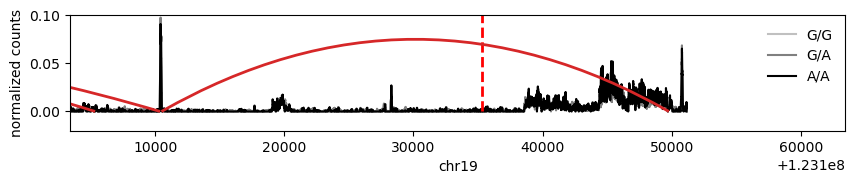

In [98]:
fig, ax = plt.subplots(figsize = (10, 1.5))

var_h = 0.3
    

ax.plot(x, smoothed_mean, c = 'silver', label = 'G/G')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hets)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+smooth]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='gray', label='G/A')

mean_counts = np.array(np.log1p(rpkm_ba9).loc[pd.Index(hom_refs)].mean(axis=0))
smoothed_mean = [np.mean(mean_counts[i:i+smooth]) for i in range(len(mean_counts))]
ax.plot(x, smoothed_mean, c='black', label = 'A/A')

# var_loc = 56076841
if True:
    ax.plot([var_loc, var_loc], [0, var_h], linestyle='--', c='red', linewidth=2)
ax.legend(frameon=False)
ax.set_xlabel('chr19')
# ax.set_yticks([np.log1p(0), np.log1p(1), np.log1p(10)])
# ax.set_yticklabels(['0', '1', '10'])
ax.set_ylabel('normalized counts')

# if xlim1 and xlim2:
ax.set_xlim([first_pos + 120000, first_pos + 180000])

# if ylim:
ax.set_ylim([-0.02, 0.1])

plot_junction(123034686, 123105354, ax=ax, height=0.15)
plot_junction(123110489, 123149775, ax=ax, height=0.15)
plot_junction(123034686,123110384, ax=ax, height=0.15)
# plot_junction(123152626,123160780, ax=ax, height=0.15)

In [94]:
x_cols[-1]

123151139

In [66]:
first_pos + 120000

123103430

In [61]:
first_pos + 180000

123163430

In [67]:
juncs = run_tabix_on_junc(junc_file, ['chr12:123103430', 'chr12:123271563'], transform_to_df = True)

In [97]:
juncs.head(10)

,chrom,start,end,name
0,chr12,123034686,123105354,junction_1
1,chr12,123034686,123110384,junction_2
2,chr12,123110489,123149775,junction_3


In [89]:
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
import matplotlib.path as mpath

def plot_junction(start, end, ax=None, height=1, c='red'):

    Path = mpath.Path
    midpoint = np.mean([start, end])

    if ax is None:
        fig, ax = plt.subplots()
    pp1 = mpatches.PathPatch(
        Path([(start, 0), (midpoint, height), (end, 0)],
             [Path.MOVETO, Path.CURVE3, Path.CURVE3]),
        fc="none", transform=ax.transData, color='tab:red', linewidth=2, zorder=2)
    
    ax.add_patch(pp1)
    


In [44]:
pp1